In [1]:
import cv2
from mtcnn.mtcnn import MTCNN
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import scipy.ndimage as ndi

Using TensorFlow backend.


In [8]:
def detect_face(image):
    
    results = detector.detect_faces(image)
    print(results)
    if len(results) == 0:
        return None
    
    x, y, w, h = results[0]['box']
    x , y, w, h = abs(x), abs(y), abs(w), abs(h)
    x1, y1, x2, y2 = x, y, x+w, y+h
    
    keypoints = results[0]['keypoints']
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    cv2.rectangle(image, (x1,y1), (x2,y2), (0,155,255), 2)
    cv2.circle(image, left_eye, 1, (0,255,255), 2)
    cv2.circle(image, right_eye, 1, (0,255,255), 2)
    
    face = image[y:y+h, x:x+w]
    
    return keypoints, face

In [9]:
def get_eyes_info(eye_centers):
    right_eye_centers = eye_centers['left_eye'] #(y,x)
    left_eye_centers = eye_centers['right_eye']
    
    dx = right_eye_centers[0] - left_eye_centers[0]
    dy = right_eye_centers[1] - left_eye_centers[1]
    
    return right_eye_centers, left_eye_centers, dx, dy

In [10]:
def get_angle_scale(eye_centers):
    
    right_eye_centers, left_eye_centers, dx, dy = get_eyes_info(eye_centers)
    angle = np.degrees(np.arctan2(dy, dx)) - 180
    
    middleOfeyes = ((left_eye_centers[0]+right_eye_centers[0])//2, (left_eye_centers[1]+right_eye_centers[1])//2)
    
    desired_right_eye_x = 1.0 - desired_left_eye[0]
    org_dist = np.sqrt((dx **2) + (dy**2))
    desired_dist = desired_right_eye_x - desired_left_eye[0]
    desired_dist *= 256
    scale = desired_dist/org_dist
    
    return angle, middleOfeyes, scale

In [11]:
def face_normalize(image, eye_centers):
    
    angle, middleOfeyes, scale = get_angle_scale(eye_centers)
    
    print(int(angle))
    print(middleOfeyes)
    
    M = cv2.getRotationMatrix2D(middleOfeyes, angle, scale)
    
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    
    M[0,2] += (tX - middleOfeyes[0])
    M[1,2] += (tY - middleOfeyes[1])
    
    (w, h) = (desired_face_width, desired_face_height)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    
    return output

In [57]:
def image_smoothing(image):
    gf = ndi.gaussian_filter(image, sigma=4.0)
    smooth_image = image / (gf + 0.000001)
    
    return smooth_image

In [129]:
def extract_eye_regions(image, eye_centers):

    right_eye_centers, left_eye_centers, dx, dy = get_eyes_info(eye_centers)
    dist_btwn_eyes = abs(np.sqrt((dx**2) + (dy**2)))
    
    half_dist = int(dist_btwn_eyes/2)
    up_down = int(0.3 * half_dist)
    
    left_right = int(0.5 * half_dist)
    
    x, y = int(right_eye_centers[0]), int(right_eye_centers[1])
    right_eye_region = image[y-up_down:y+up_down, x-left_right:x+left_right]
    
    x, y = int(left_eye_centers[0]), int(left_eye_centers[1])
    left_eye_region = image[y-up_down:y+up_down, x-left_right:x+left_right]
    
    return cv2.resize(left_eye_region, (20,20)), cv2.resize(right_eye_region, (20,20))
    

In [156]:
def binarize_eye_regions(image, eye_centers):
    left_eye_region , right_eye_region = extract_eye_regions(image, eye_centers)
    
    left_region_mean = left_eye_region.mean()
    right_region_mean = right_eye_region.mean()
    
    plt.imshow(left_eye_region)
    plt.title('Left Eye Region')
    plt.show()
    
    
    left_eye_region = cv2.threshold(left_eye_region, left_region_mean, 255, cv2.THRESH_BINARY)[1]
    right_eye_region = cv2.threshold(right_eye_region, right_region_mean, 255, cv2.THRESH_BINARY)[1]
    
    return left_eye_region, right_eye_region

In [154]:
def get_result(bin_left_regions, bin_right_regions):
    
    left_region_scores  = [np.count_nonzero(bin_left_regions[i]!=bin_left_regions[i-1]) for i in bin_left_regions if i>1 ]
    right_region_scores  = [np.count_nonzero(bin_right_regions[i]!=bin_left_regions[i-1]) for i in bin_regions if i>1 ]
    
    avg_score = (sum(left_region_scores + right_region_scores))// (len(left_region_scores)*2)
    print('Average Score')
    
    
    if avg_score > 30:
        return 'Live'
    else:
        return 'Fake'

[{'box': [308, 270, 159, 203], 'confidence': 0.9999175071716309, 'keypoints': {'left_eye': (355, 348), 'right_eye': (431, 344), 'nose': (393, 386), 'mouth_left': (365, 427), 'mouth_right': (429, 425)}}]


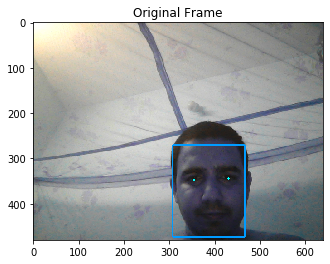

-3
(393, 346)


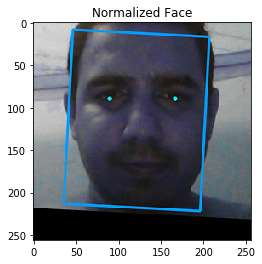

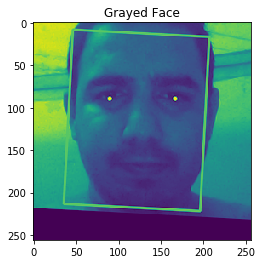

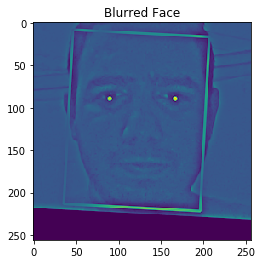

[{'box': [46, 7, 157, 213], 'confidence': 0.9995941519737244, 'keypoints': {'left_eye': (91, 89), 'right_eye': (168, 89), 'nose': (129, 131), 'mouth_left': (95, 169), 'mouth_right': (160, 171)}}]


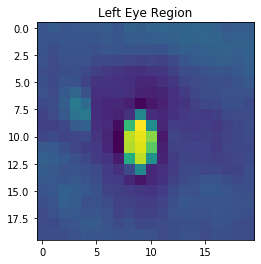

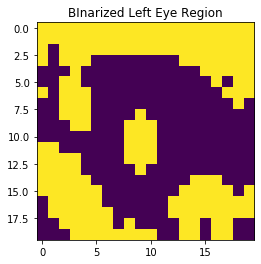

5
[{'box': [310, 271, 157, 202], 'confidence': 0.9994619488716125, 'keypoints': {'left_eye': (356, 346), 'right_eye': (431, 344), 'nose': (392, 387), 'mouth_left': (363, 428), 'mouth_right': (426, 428)}}]


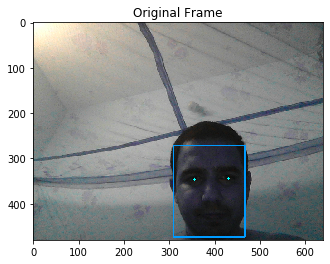

-1
(393, 345)


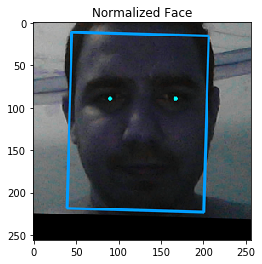

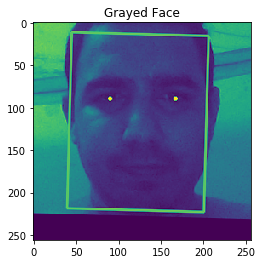

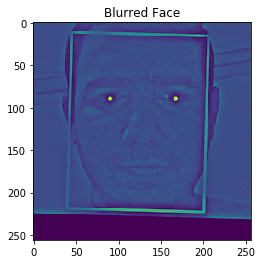

[{'box': [46, 10, 156, 210], 'confidence': 0.9998416900634766, 'keypoints': {'left_eye': (90, 89), 'right_eye': (167, 90), 'nose': (125, 133), 'mouth_left': (93, 171), 'mouth_right': (159, 173)}}]


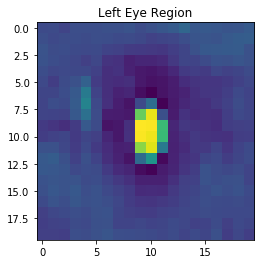

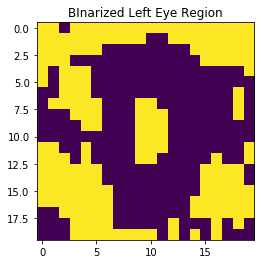

4
[{'box': [311, 267, 157, 204], 'confidence': 0.9975511431694031, 'keypoints': {'left_eye': (355, 344), 'right_eye': (429, 341), 'nose': (390, 385), 'mouth_left': (364, 427), 'mouth_right': (426, 426)}}]


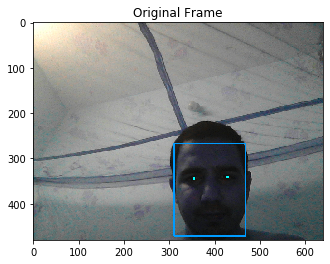

-2
(392, 342)


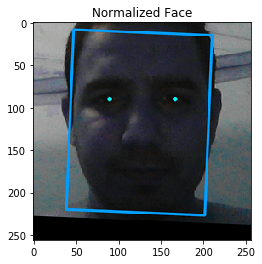

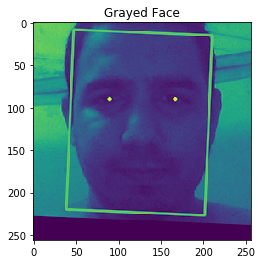

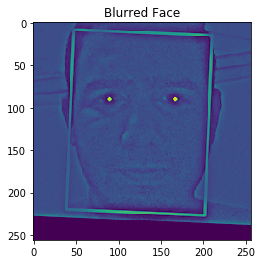

[{'box': [46, 9, 159, 216], 'confidence': 0.9995959401130676, 'keypoints': {'left_eye': (90, 90), 'right_eye': (167, 91), 'nose': (124, 135), 'mouth_left': (92, 174), 'mouth_right': (157, 176)}}]


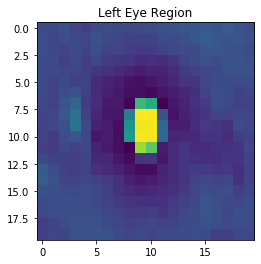

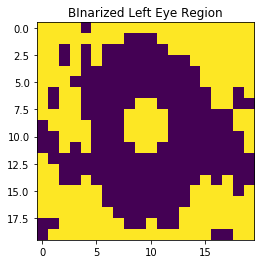

3
[{'box': [311, 266, 158, 206], 'confidence': 0.9973719120025635, 'keypoints': {'left_eye': (354, 344), 'right_eye': (429, 341), 'nose': (389, 385), 'mouth_left': (363, 428), 'mouth_right': (426, 426)}}]


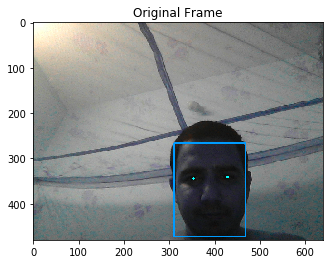

-2
(391, 342)


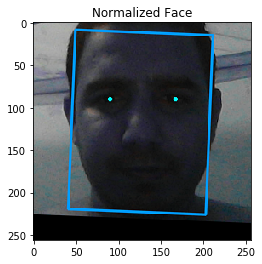

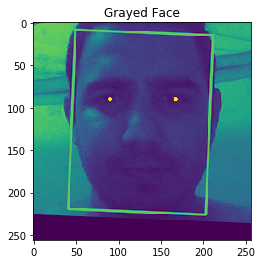

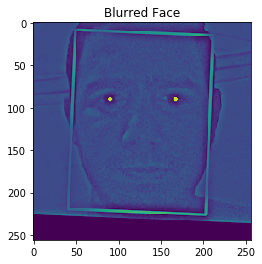

[{'box': [46, 11, 157, 212], 'confidence': 0.9994799494743347, 'keypoints': {'left_eye': (91, 90), 'right_eye': (167, 91), 'nose': (125, 135), 'mouth_left': (94, 173), 'mouth_right': (158, 175)}}]


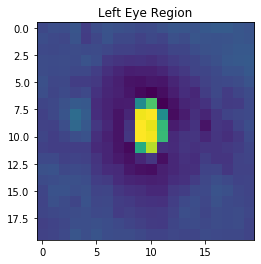

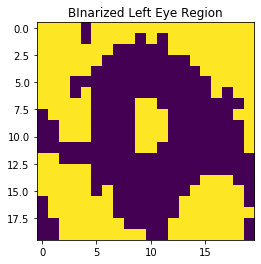

2
[{'box': [309, 268, 159, 207], 'confidence': 0.9985309839248657, 'keypoints': {'left_eye': (353, 346), 'right_eye': (428, 342), 'nose': (388, 387), 'mouth_left': (361, 429), 'mouth_right': (424, 428)}}]


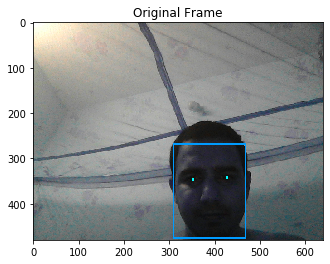

-3
(390, 344)


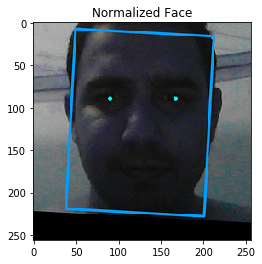

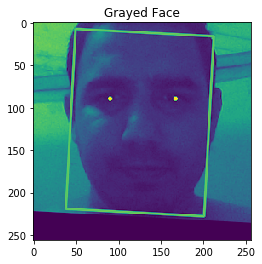

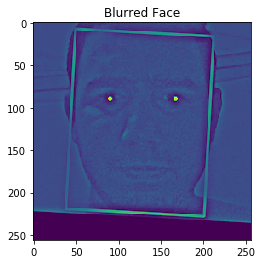

[{'box': [45, 10, 159, 214], 'confidence': 0.9995501637458801, 'keypoints': {'left_eye': (90, 90), 'right_eye': (168, 90), 'nose': (124, 134), 'mouth_left': (94, 174), 'mouth_right': (159, 175)}}]


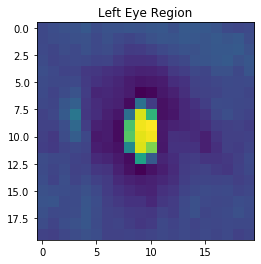

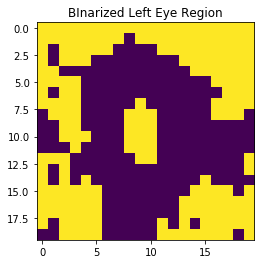

1
Average Score
Result of Liveliness :  Live


In [161]:
video = cv2.VideoCapture(0)
duration_th = 5

desired_left_eye = (0.35, 0.35)
desired_face_width = 256
desired_face_height = 256

bin_left_regions = {}
bin_right_regions = {}
result = ''
detector = MTCNN()

while(duration_th):
    ret, frame = video.read()
    
    
    #1. Face Detection
    eye_centers, face = detect_face(frame)
    
    plt.imshow(frame)
    plt.title('Original Frame')
    plt.show()
    
    #2. Face Region Normalization
    normalized_face = face_normalize(frame, eye_centers)
    plt.imshow(normalized_face)
    plt.title('Normalized Face')
    plt.show()
    
    grayed_image = cv2.cvtColor(normalized_face, cv2.COLOR_BGR2GRAY)
    plt.imshow(grayed_image)
    plt.title('Grayed Face')
    plt.show()
    
    #3. Smoothing
    blurred_face = image_smoothing(grayed_image)
    plt.imshow(blurred_face)
    plt.title('Blurred Face')
    plt.show()
    
    #4. New Eye Coordinates after Scaling and Rotation
    new_eye_cords, new_face = detect_face(normalized_face)
    
    #4. Eye Region Binarization
    bin_left_eye_region, bin_right_eye_region = binarize_eye_regions(blurred_face, new_eye_cords)
    
    plt.imshow(bin_left_eye_region)
    plt.title('BInarized Left Eye Region')
    plt.show()
    
    bin_left_regions[duration_th] = bin_left_eye_region
    bin_right_regions[duration_th] = bin_right_regions
    
    print(duration_th)
    if (duration_th == 1):
        result = get_result(bin_left_regions, bin_right_regions)
    
    duration_th -= 1
    
    cv2.imshow('Capture Image', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
print('Result of Liveliness : ', result)
# When everything done, release the capture
video.release()
cv2.destroyAllWindows()